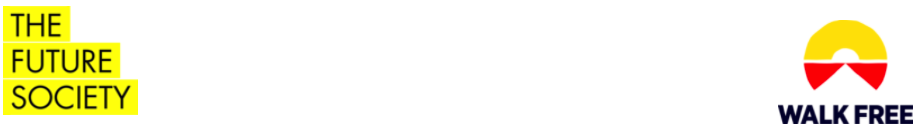

#*Project AIMS (AI against Modern Slavery)*
---



 
##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1mPpfItPtv3J1NNELeLjmP4RKBmKzJytx/view?usp=sharing).

The notebook fetches the UK Modern Slavery Act.csv from [WikiRate website](https://wikirate.org/uk_modern_slavery_act_research). There are several columns in the dataset. The script works with the "Source Page" column. This column points to a Wikirate page that includes a link to the original PDF of the statement. We download the PDF, parse it using textract, and add the text to the column.


##Setup

In [ ]:
!apt-get install python-dev libxml2-dev libxslt1-dev antiword unrtf poppler-utils pstotext tesseract-ocr flac ffmpeg lame libmad0 libsox-fmt-mp3 sox libjpeg-dev swig libpulse-dev
!pip install textract
!pip install cleantext
!pip install nltk
!pip install pdfminer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
python-dev is already the newest version (2.7.15~rc1-1).
antiword is already the newest version (0.37-11build1).
flac is already the newest version (1.3.2-1).
lame is already the newest version (3.100-2).
pstotext is already the newest version (1.9-6build1).
swig is already the newest version (3.0.12-1).
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
unrtf is already the newest version (0.21.9-clean-3).
libpulse-dev is already the newest version (1:11.1-1ubuntu7.11).
libxml2-dev is already the newest version (2.9.4+dfsg1-6.1ubuntu1.4).
libxslt1-dev is already the newest version (1.1.29-5ubuntu0.2).
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
libmad0 is already the newest version (0.15.1b-9ubuntu18.04.1).
libsox-fmt-mp3 is already th

In [ ]:
# Import requests
import requests
#Import pandas, numpy, beautifulsoup4
import pandas as pd
import numpy as np
import bs4
import traceback

from cleantext import clean
import nltk
import re
import os
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import textract

ModuleNotFoundError: ignored

# Download dataset
 


In [ ]:
# Create variable with Wikirate data:  https://wikirate.org/UK_Modern_Slavery_Act_Research+Answer.csv
csv_data_url = "https://wikirate.org/UK_Modern_Slavery_Act_Research+Answer.csv"

In [ ]:
# Download the data
data = pd.read_csv("https://wikirate.org/UK_Modern_Slavery_Act_Research+Answer.csv")

In [ ]:
len(data)

500

In [ ]:
data.head()
#data_slice = data.sample(100)
data_slice = data

NameError: ignored

Store the data of the PDFs temporarily before parsing. We do not delete the files later. Keep in mind deleting them is necessary if this is run on a local machine.
 

In [ ]:
statement_folder = "/tmp/statements/"
try:
  os.mkdir("/tmp/statements/")
except:
  print("Skipping dir creation")

In [ ]:
def url_to_filename(url):
    return statement_folder+'.'.join(url.split("/")[-4:]).replace(".","_")+url[-4:]

def clean_text(text):
  return re.sub("\\\\(x..|n)"," ",clean(text))

# Create a function that downloads data from the Source Page column
def download_statement_bytes(row):
    wikirate_url = row["Source Page"]
    #print(f"Downloading from {wikirate_url}")
    html = requests.get(wikirate_url).content
    # If there is an error downloading, return a dict with an error
    if html is None:
        return {"error": "Could not download statement"}
    # Otherwise, return the html

    print(f"Fetched html, {len(html)}")
    try:
        soup = bs4.BeautifulSoup(html, "html.parser")       
        download_tag = soup.find("i", class_="fa-download")
        download_tag_parent = download_tag.parent
        download_url = download_tag_parent["href"]
        filename = download_url.split("/")[-1]
        unique_filename = url_to_filename(filename)
        if not os.path.exists(unique_filename):
          #print(f"Downloading {unique_filename}")
          bytes = requests.get(download_url).content
          #print("Downloaded file")
        else:
          #print(f"Reading {unique_filename}")
          with open(unique_filename, "rb") as f:
            bytes = f.read()

        return {"object": bytes, "filename": filename , "download_url":download_url , "wikirate_url": wikirate_url, "extension": download_url[-4:]}
    except Exception as e:
        print("Error trying to fetch")
        print(e)
        return {"error": "Could not find download link"}    
    


    
def fetch_and_parse(row):
  pdf_object = download_statement_bytes(row)
  if "error" in pdf_object:
    return "ERROR - " + pdf_object["error"]
  else:
    unique_filename = url_to_filename(pdf_object["filename"])
    if not os.path.exists(unique_filename):
    #  print(f"Saving file {unique_filename}")
      with open(unique_filename, "wb") as f:
        f.write(pdf_object["object"])
    #else:
    #  print(f"File exists! {unique_filename}")
    
    #print("Textracting")
    try:
      extracted = textract.process(unique_filename)
    #print("Cleaning")
      final_text = clean_text(extracted)
    except Exception as e:
      print(f"Couldn't extract text for statement at {unique_filename}, {pdf_object['wikirate_url']}")
      print(traceback.format_exc())
      return "ERROR EXTRACTING TEXT"

    #os.remove(unique_filename)
    return final_text

In [ ]:
%%time
data_slice = data
data_slice["statement"] = data_slice.apply(fetch_and_parse,axis=1)

Fetched html, 28201
Fetched html, 28126
Fetched html, 28197
Fetched html, 28175
Fetched html, 28074
Fetched html, 28071
Fetched html, 28197
Fetched html, 28213
Fetched html, 28201
Fetched html, 27706
Couldn't extract text for statement at /tmp/statements/25997106_pdf.pdf, https://wikirate.org/~8078276
Traceback (most recent call last):
  File "<ipython-input-39-46f144883b04>", line 58, in fetch_and_parse
    extracted = textract.process(unique_filename)
  File "/usr/local/lib/python3.7/dist-packages/textract/parsers/__init__.py", line 79, in process
    return parser.process(filename, input_encoding, output_encoding, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/textract/parsers/utils.py", line 46, in process
    byte_string = self.extract(filename, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/textract/parsers/pdf_parser.py", line 29, in extract
    raise ex
  File "/usr/local/lib/python3.7/dist-packages/textract/parsers/pdf_parser.py", line 21, in extract
    re

In [ ]:
#data_slice.to_csv("labeled-dataset-11-21.csv")

,Answer ID,Answer Page,Metric,Company,Year,Value,Source Page,Original Source,Source Count,Comments,statement
0,8101343,https://wikirate.org/~8101343,Walk Free Foundation+MSA risk management (revi...,"The Capital Group Companies, Inc.",2021,No,https://wikirate.org/~8101299,https://www.capitalgroup.com/content/dam/cgc/t...,1,"No required information found. ""We consider th...","b""CAPITAL INTERNATIONAL LIMITED ( CIL ) Th..."
1,7906125,https://wikirate.org/~7906125,Business & Human Rights Resource Centre+Modern...,Odey Asset Management LLP,2021,Yes - UK Modern Slavery Act,https://wikirate.org/~7906117,https://www.odey.com/media/isqls3hp/odey-group...,1,pg. 2 Singh Anjali[https://wikirate.org/Singh_...,b' '
2,7622447,https://wikirate.org/~7622447,Business & Human Rights Resource Centre+MSA st...,GROUP ZARA AUSTRALIA PTY LIMITED,2021,Yes,https://wikirate.org/~7622436,https://www.inditex.com/en/our-commitment-to-p...,1,"Statement not present on Zara website, but lin...","b""English Espa ol EUR 28,77 Cambio: 0,24 (%0..."
3,8159386,https://wikirate.org/~8159386,Business & Human Rights Resource Centre+MSA st...,Chanel (Australia) Pty Ltd,2021,Yes,https://wikirate.org/~8159377,https://modernslaveryregister.gov.au/statement...,1,NaN,b' Home The Register Published statement ...
4,7613768,https://wikirate.org/~7613768,Walk Free Foundation+MSA risk assessment,Richemont,2021,No,https://wikirate.org/~7613712,https://www.richemont.com/media/o5cdiwzp/slave...,1,"""Richemont also monitors on-going compliance a...",b'SLAVERY & HUMAN TRAFFICKING STATEMENT The Ca...
...,...,...,...,...,...,...,...,...,...,...,...
495,8114539,https://wikirate.org/~8114539,Core+Supplier List,Kering,2021,"Yes, Tier 1 only",https://wikirate.org/~7472372,https://equilibrium.gucci.com/responsible-supp...,1,Gucci represents 59% of the revenues of Luxury...,ERROR - Could not find download link
496,8159149,https://wikirate.org/~8159149,Walk Free Foundation+MSA Impact on Company Beh...,Facebook Inc.,2021,No,https://wikirate.org/~8159074,https://s21.q4cdn.com/399680738/files/doc_down...,1,NaN,b'Facebook s Anti-Slavery and Human Traffick...
497,8103186,https://wikirate.org/~8103186,Walk Free Foundation+MSA incidents remediation...,Wellington Management Company,2021,Cancel contracts,https://wikirate.org/~8103100,https://www.wellington.com/uploads/2021/04/b3e...,1,"pg. 2 ""SUPPLIER ADHERENCE TO OUR VALUES We hav...",b'WELLINGTON MANAGEMENT INTERNATIONAL LTD SLA...
498,7614144,https://wikirate.org/~7614144,Walk Free Foundation+MSA policy (revised),DSW Inc.,2021,Suppliers comply with laws and company’s polic...,https://wikirate.org/~7614107,NaN,1,The company provides a link of the code of con...,"b""7/14/2021 Supply Chain Transparency | DSW ..."


In [ ]:
# Cleanup and remove data from the temporary directory...

In [ ]:
data_slice.to_csv("labeled_data.csv")

In [ ]:
data_slice["statement"].apply(lambda x:len(x)).sort_values()

In [ ]:
data_slice["statement"][165]

In [ ]:
data_slice["err"] = data_slice["statement"].apply(lambda x: "ERROR" in x)

In [ ]:
data_slice[ data_slice["err"]==True ]

,Answer ID,Answer Page,Metric,Company,Year,Value,Source Page,Original Source,Source Count,Comments,statement,err
9,8078288,https://wikirate.org/~8078288,Walk Free Foundation+MSA historic record,Man Group plc,2021,Yes,https://wikirate.org/~8078276,https://www.man.com/,1,"Yes, Modern slavery (footer) on the company's ...",ERROR EXTRACTING TEXT,True
11,8132461,https://wikirate.org/~8132461,Business & Human Rights Resource Centre+MSA st...,"Morgan Stanley Investment Management, Inc.",2021,Yes,https://wikirate.org/~8132444,https://www.morganstanley.com/,1,Morgan Stanley Homepage > Corporate governance...,ERROR EXTRACTING TEXT,True
21,8040178,https://wikirate.org/~8040178,Business & Human Rights Resource Centre+MSA st...,Aviva Investors,2021,Yes,https://wikirate.org/~8040168,https://www.aviva.co.uk/,1,Down in the footer as Modern slavery statement...,ERROR EXTRACTING TEXT,True
25,8132466,https://wikirate.org/~8132466,Business & Human Rights Resource Centre+MSA st...,Morgan Stanley Investment Management Co.,2021,Yes,https://wikirate.org/~8132452,https://www.morganstanley.com/,1,Morgan Stanley Homepage > Corporate governance...,ERROR EXTRACTING TEXT,True
26,8040184,https://wikirate.org/~8040184,Walk Free Foundation+MSA historic record,Aviva Investors,2021,Yes,https://wikirate.org/~8040168,https://www.aviva.co.uk/,1,"Yes, past year's statements are available on t...",ERROR EXTRACTING TEXT,True
...,...,...,...,...,...,...,...,...,...,...,...,...
455,8047931,https://wikirate.org/~8047931,Walk Free Foundation+MSA historic record,Canaccord Genuity Limited,2021,Yes,https://wikirate.org/~8047917,https://www.canaccordgenuity.com/,1,The company provides previous year's statement...,ERROR EXTRACTING TEXT,True
471,7620709,https://wikirate.org/~7620709,Core+Supplier List,SIMBA TEXTILE MILLS PTY LTD,2021,No,https://wikirate.org/~7620699,https://www.simba.global/,1,The supplier list is not found on the homepage...,ERROR EXTRACTING TEXT,True
476,7620715,https://wikirate.org/~7620715,Commons+Shareholder Disclosure,SIMBA TEXTILE MILLS PTY LTD,2021,No,https://wikirate.org/~7620699,https://www.simba.global/,1,Shareholder disclosure is not found on the hom...,ERROR EXTRACTING TEXT,True
490,7614139,https://wikirate.org/~7614139,Walk Free Foundation+MSA supply chain disclosure,DSW Inc.,2021,No,https://wikirate.org/~7614107,NaN,1,No information found. Singh Anjali[https://wik...,ERROR - Could not find download link,True


In [ ]:
len(data_slice)

500